# Import packages

In [1]:
import os
import cmaps
import cmocean
import numpy as np
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from datetime import date
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import Polygon
from matplotlib import rcParams
from xarrayMannKendall import Mann_Kendall_test
directory   = '/srv/scratch/z3533156'
from dask.distributed import Client
from astropy import convolution
rcParams['font.family'] = 'sans-serif'
import PUG_functions as PF

# Read SSH data

In [2]:
dataset = xr.open_dataset(directory+'/BRAN_MHW/SO/daily/AVISO/AVISO_monthly_SSH.nc')
lon = np.tile(dataset.lon, (len(dataset.lat[40:242]),1)).transpose()+180
lat = np.tile(dataset.lat[40:242], (len(dataset.lon),1))
SSH_data = dataset.adt
large_scale_ssh = SSH_data.copy()
kernel=np.ones((1,13,13))
large_scale_ssh.data = convolution.convolve(SSH_data,boundary='wrap', kernel = kernel, preserve_nan=True)
large_scale_ssh=large_scale_ssh.rolling(time=12,center=True).mean()
large_scale_ssh0=np.transpose(large_scale_ssh.data[:,40:242,:])
large_scale_ssh1=np.concatenate((large_scale_ssh0[720:,:,:],large_scale_ssh0[:720,:,:]),axis=0)
large_scale_ssh2=large_scale_ssh1.copy()
large_scale_ssh3=large_scale_ssh1.copy()
large_scale_ssh1[:60,:,:]=np.nan;
large_scale_ssh1[485:,:,:]=np.nan;
large_scale_ssh2[:579,:,:]=np.nan;
large_scale_ssh2[1201:,:,:]=np.nan;
large_scale_ssh3[:1225,:,:]=np.nan;

# Read the latitudes of the southern boundaries of the Subtropical Gyres

In [3]:
dataset1   = sio.loadmat(directory+'/BRAN_MHW/SO/daily/Figure4_lat_SG_WBC.mat')
lon0       = dataset1['lon0'][:,0]
lat_SG     = dataset1['lat_SG']
lat_SG_ARC_trend = dataset1['lat_SG_ARC_trend'][:,0]
lat_SG_EAC_trend = dataset1['lat_SG_EAC_trend'][:,0]
lat_SG_BC_trend  = dataset1['lat_SG_BC_trend'][:,0]
lat_SG_ARC_mean  = dataset1['lat_SG_ARC_mean'][:,0]
lat_SG_EAC_mean  = dataset1['lat_SG_EAC_mean'][:,0]
lat_SG_BC_mean   = dataset1['lat_SG_BC_mean'][:,0]
lat_SG_mean      = np.array((lat_SG_ARC_mean,lat_SG_EAC_mean,lat_SG_BC_mean))
#################################
ds = xr.Dataset(data_vars=dict(lat_SG_mean=(["latitude","time"], lat_SG_mean)))
lat_SG_WBC_mean0 = ds.lat_SG_mean
lat_SG_WBC_mean1 = lat_SG_WBC_mean0.sortby('time')
lat_SG_WBC_mean  = Mann_Kendall_test(lat_SG_WBC_mean1,'time',MK_modified=True,method="linregress",alpha=0.05,
                                coords_name = {'time':'time','x':'latitude'})
lat_SG_WBC_mean_trend = lat_SG_WBC_mean.compute()
time_start = np.datetime64('1993-07')
time_end   = np.datetime64('2020-08')
t_range    = PF.time_range(time_start,time_end,'monthly','np64')
x_lon      = np.tile(lon0,(np.size(t_range),1)).transpose()
y_month    = np.tile(t_range,(np.shape(lon0)[0],1))

# Plot the latitudes of the southern boundaries of the Subtropical Gyres and their trends

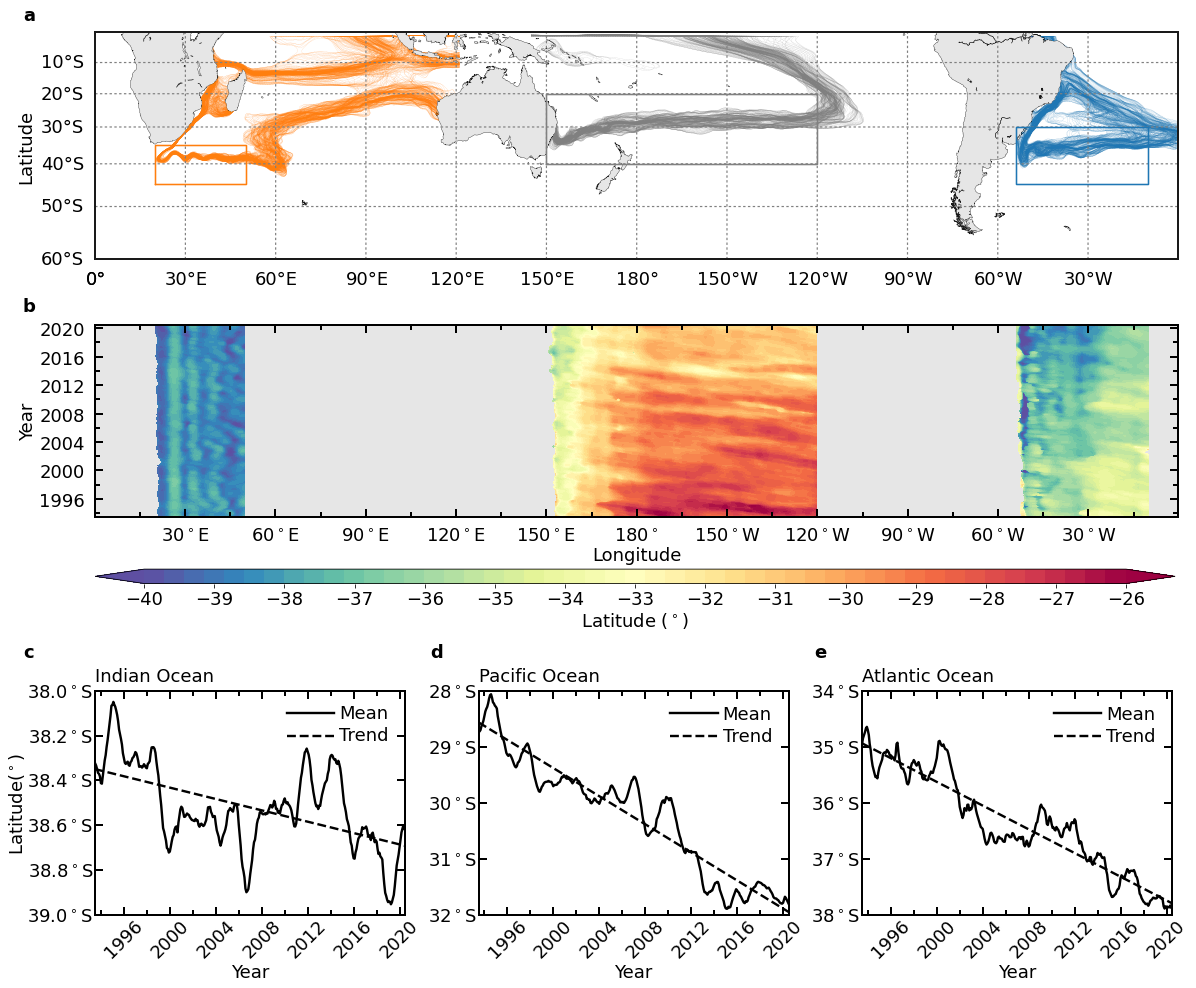

In [6]:
fig_ratio=0.9
fig = plt.figure(figsize=(30, 20))
gs=gridspec.GridSpec(3,3)
labelfont=18
padspacescale=10
labelpadscale=2
linefont = 1.2
scale  = 1.0
##################################################################################
# domains of Subtropical Gyres
lon_SG_ARC1 = np.array([20,50,50,20,20])
lat_SG_ARC1 = np.array([-45,-45,-35,-35,-45])
lon_SG_EAC1 = np.array([150,240,240,150,150])
lat_SG_EAC1 = np.array([-40,-40,-20,-20,-40])
lon_SG_BC1 = np.array([350,306,306,350,350])
lat_SG_BC1 = np.array([-30,-30,-45,-45,-30])
ax = fig.add_subplot(gs[0:2])
l, b, w, h = ax.get_position().bounds
m   = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat= 0,llcrnrlon=0,urcrnrlon=360,resolution='l')    
m.drawmeridians(np.arange(0,360, 30),labels=[0,0,0,1],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont,family='sans-serif')
m.drawparallels(np.arange(-60,-0, 10),labels=[1,0,0,0],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont,family='sans-serif')    
m.drawcoastlines(color='0.1',  linewidth=0.3*linefont)
m.drawmapboundary(color='0.1', linewidth=0.5*linefont)
m.fillcontinents(color='0.9', lake_color='white')
x, y = m(lon, lat)
cx,cy  = m(-24, 4)
ax.set_position([l, b, scale*w, scale*h])   
ax.spines['left'].set_linewidth(labelpadscale)
ax.spines['top'].set_linewidth(labelpadscale)
ax.spines['right'].set_linewidth(labelpadscale)
ax.spines['bottom'].set_linewidth(labelpadscale)
for i in range(3):
    if i==0:
        SSH=large_scale_ssh1
    elif i==1:
        SSH=large_scale_ssh2
    else:
        SSH=large_scale_ssh3        
    for j in range(np.size(large_scale_ssh,0)):
        if i<1:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:orange')
        elif i<2:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='gray')
        else:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.59,0.61,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:blue')    
    x_SG_ARC,y_SG_ARC=m(lon_SG_ARC1,lat_SG_ARC1)
    x_SG_EAC,y_SG_EAC=m(lon_SG_EAC1,lat_SG_EAC1)
    x_SG_BC,y_SG_BC=m(lon_SG_BC1,lat_SG_BC1)
    m.plot(x_SG_ARC,y_SG_ARC,linewidth=linefont,linestyle='solid', color='tab:orange')
    m.plot(x_SG_EAC,y_SG_EAC,linewidth=linefont,linestyle='solid', color='gray')
    m.plot(x_SG_BC,y_SG_BC,linewidth=linefont,linestyle='solid', color='tab:blue')
plt.ylabel('Latitude',fontsize=labelfont,labelpad=6*padspacescale,family='sans-serif')
ax.axes.xaxis.set_tick_params(pad=0)
ax.axes.yaxis.set_tick_params(pad=0)
plt.text(cx, cy,'a',color='xkcd:black', fontsize=labelfont, weight='bold')
##################################################################################
# Plot latitudes of Subtropical Gyres
ax = fig.add_subplot(gs[3:5],facecolor='0.9')
l, b, w, h = ax.get_position().bounds
ax.set_position([l, b+0.12, 1.0*w, 0.6*h])   
ax.spines['left'].set_linewidth(labelpadscale)
ax.spines['top'].set_linewidth(labelpadscale)
ax.spines['right'].set_linewidth(labelpadscale)
ax.spines['bottom'].set_linewidth(labelpadscale)
levels     = np.linspace(-40,-26,50)
tick_marks = np.linspace(-40,-26,15)
cmaps = plt.cm.get_cmap('Spectral_r')
CB = plt.contourf(x_lon, y_month, lat_SG, cmap=cmaps,levels=levels,origin='lower',extend='both')
plt.text(x_lon[0,-1]-24, y_month[-1,-1]+24, 'b',fontsize = labelfont, color='black', weight='bold')
# xaxis
xminorLocator   = plt.MultipleLocator(15)
xmajorLocator   = plt.MultipleLocator(30)
xmajorFormatter = plt.FormatStrFormatter('%2.0f')
ax.xaxis.set_minor_locator(xminorLocator)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)        
ax.axes.xaxis.set_tick_params(pad=10)
plt.xticks(fontsize=labelfont,family='sans-serif')
plt.xticks(np.linspace(30,330,11), ['30$^\circ$E', '60$^\circ$E','90$^\circ$E', '120$^\circ$E','150$^\circ$E',
           '180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W','60$^\circ$W','30$^\circ$W'])
plt.ylim(t_range[0], t_range[-1])
yminorLocator   = mpl.dates.YearLocator(2)
ymajorLocator   = mpl.dates.YearLocator(4)
ymajorFormatter = mpl.dates.DateFormatter('%Y')
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
plt.yticks(fontsize=labelfont,family='sans-serif')
plt.tick_params(axis='x',which='minor',bottom='on',left='on',top='on',right='on',\
            length=5,width=2,colors='black',direction='in')
plt.tick_params(axis='y',which='minor',bottom='on',left='on',top='on',right='on',\
            length=5,width=2,colors='black',direction='in')
plt.tick_params(bottom='on',left='on',top='on',right='on',length=8.0,width=2,colors='black',direction='in')
ax.axes.yaxis.set_tick_params(pad=10) 
plt.ylabel('Year',fontsize=labelfont,labelpad=2,family='sans-serif')    
plt.xlabel('Longitude',fontsize=labelfont,labelpad=0.1*padspacescale,family='sans-serif')
cbaxes     = fig.add_axes([0.125, 0.465, 0.50, 0.01])
cb = plt.colorbar(CB,orientation='horizontal',cax = cbaxes)
cb.set_label(r'Latitude ($^\circ$)', fontsize=labelfont,labelpad=2,family='sans-serif')
cb.set_ticks(tick_marks)
cb.ax.tick_params(labelsize=labelfont)
labels=['Indian Ocean','Pacific Ocean','Atlantic Ocean']
for i in range(3):
    ax = fig.add_subplot(gs[i+6]) 
    l, b, w, h = ax.get_position().bounds
    b=b+0.11
    if i<1:
        plt.plot(t_range, lat_SG_ARC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_ARC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-75, -37.85, 'c',fontsize = labelfont, color='black', weight='bold')
    elif i<2:
        l=l-0.096
        plt.plot(t_range, lat_SG_EAC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_EAC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-50, -27.4, 'd',fontsize = labelfont, color='black', weight='bold')
    else:
        l=l-0.192
        plt.plot(t_range, lat_SG_BC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_BC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-50, -33.4, 'e',fontsize = labelfont, color='black', weight='bold')
        
    ax.set_position([l, b, w*0.63, h*0.7])
    plt.title(labels[i], fontsize=labelfont,loc='left',pad=padspacescale,family='sans-serif')
    plt.xlim(t_range[0], t_range[-1])
    xminorLocator   = mpl.dates.YearLocator(2)
    xmajorLocator   = mpl.dates.YearLocator(4)
    xmajorFormatter = mpl.dates.DateFormatter('%Y')
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_major_formatter(xmajorFormatter)
    plt.xticks(fontsize=labelfont,rotation=45)
    ax.axes.xaxis.set_tick_params(pad=labelpadscale*0.5)
    plt.xlabel('Year',fontsize=labelfont,labelpad=2,family='sans-serif')

    if i<1:
        plt.ylim(-39, -38)
        yminorLocator   = plt.MultipleLocator(0.1)
        ymajorLocator   = plt.MultipleLocator(0.2)        
        plt.plot([t_range[200],t_range[250]], [-38.1,-38.1], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-38.2,-38.2], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -38.12, 'Mean',fontsize = labelfont, color='black',family='sans-serif')
        plt.text(t_range[255], -38.22, 'Trend',fontsize = labelfont, color='black',family='sans-serif')
        plt.ylabel(r'Latitude($^\circ$)',fontsize=labelfont,labelpad=0,family='sans-serif')
        ax.set_yticks(np.linspace(-39,-38,6))
        ax.set_yticklabels(['39.0$^\circ$S','38.8$^\circ$S','38.6$^\circ$S','38.4$^\circ$S','38.2$^\circ$S','38.0$^\circ$S'])
    elif i<2:
        yminorLocator   = plt.MultipleLocator(0.5)
        ymajorLocator   = plt.MultipleLocator(1)
        plt.ylim(-32, -28)
        plt.plot([t_range[200],t_range[250]], [-28.4,-28.4], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-28.8,-28.8], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -28.5, 'Mean',fontsize = labelfont, color='black',family='sans-serif')
        plt.text(t_range[255], -28.9, 'Trend',fontsize = labelfont, color='black',family='sans-serif')
        ax.set_yticks(np.linspace(-32,-28,5))
        ax.set_yticklabels(['32$^\circ$S','31$^\circ$S','30$^\circ$S','29$^\circ$S','28$^\circ$S'])
    else:
        yminorLocator   = plt.MultipleLocator(1)
        ymajorLocator   = plt.MultipleLocator(1)
        plt.ylim(-38, -34)  
        plt.plot([t_range[200],t_range[250]], [-34.4,-34.4], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-34.8,-34.8], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -34.5, 'Mean',fontsize = labelfont, color='black',family='sans-serif')
        plt.text(t_range[255], -34.9, 'Trend',fontsize = labelfont, color='black',family='sans-serif')
        ax.set_yticks(np.linspace(-38,-34,5))
        ax.set_yticklabels(['38$^\circ$S','37$^\circ$S','36$^\circ$S','35$^\circ$S','34$^\circ$S'])
    plt.yticks(fontsize=labelfont,family='sans-serif')
    ax.axes.yaxis.set_tick_params(pad=labelpadscale)
    ax.spines['bottom'].set_linewidth(labelpadscale)
    ax.spines['left'].set_linewidth(labelpadscale)
    ax.spines['top'].set_linewidth(labelpadscale)
    ax.spines['right'].set_linewidth(labelpadscale)
    plt.tick_params(axis='x',which='minor',bottom='on',left='on',top='on',right='on',\
                length=5,width=2,colors='black',direction='in')
    plt.tick_params(axis='y',which='minor',bottom='on',left='on',top='on',right='on',\
                length=5,width=2,colors='black',direction='in')
    plt.tick_params(bottom='on',left='on',top='on',right='on',length=8.0,width=2,colors='black',direction='in')
fig.savefig(directory+'/BRAN_MHW/SO/daily/Figure4_ssh_contour.pdf',dpi=300,bbox_inches = 'tight')